In [30]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import json
import argparse
import ipfshttpclient
import hashlib
import faiss
import json
from io import BytesIO
import datetime
import sqlite3
import base64

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append("..")

from demo.image_similarity_keras.model import SiameseModel

In [8]:
def cid_to_int(cid):
    return int(hashlib.sha256(cid.encode()).hexdigest(), 16) % (2**31 - 1)

In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

model_path = "../demo/models/ConvNext_Large_64b_100ep_final"
augmentation_config = "../demo/configs/default_augmentation.json"

# Load model config
with open(os.path.join(model_path, "configs.json"), "r") as f:
    model_config = json.load(f)

    # Convert to Namespace
    model_config_ns = argparse.Namespace(**model_config)

# Load augmentation config
with open(augmentation_config, "r") as f:
    augmentation_config = json.load(f)
    
# Convert model_config dictionary to a namespace
model_config_ns = argparse.Namespace(**model_config)

# Get the image_size from model_config or use default value if missing
default_image_size = 224
image_size = model_config.get('image_size', default_image_size)

# Initialize model
model = SiameseModel(**model_config)

# Build and compile model
model.build(False)

# Load weights
model.model.load_weights(os.path.join(model_path, "weights"))

client = ipfshttpclient.connect(timeout=300)

conn = sqlite3.connect('nft.db')
cursor = conn.cursor()

Model: "siamese_ConvNext_Large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvNext_Large (KerasLayer)  (None, 1536)             196230336 
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 out_emb (Dense)             (None, 128)               32896     
                                                                 
 l2_norm (Lambda)            (None, 128)               0         
                                                                 
Total params: 197,181,504
Trainable params: 951,168
Non-trainable params: 196,230,336
_________________________________________________________________


In [10]:
def reset():
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS current (
        id INTEGER PRIMARY KEY,
        hash TEXT NOT NULL
    )
    ''')
    cursor.execute("DELETE FROM current")
    cursor.execute("INSERT INTO current SELECT * FROM base")
    conn.commit()
    
    index = faiss.read_index('base.index')
    faiss.write_index(index, 'current.index')
    
    items = client.files.ls("/nft_images/new_images")['Entries']
    if items:
        for item in items:
            client.files.rm(f"{path}/{item['Name']}", recursive=True)

In [36]:
def check_and_register(img_file):
    result = {}
    index = faiss.read_index('current.index')
    
    test_img = Image.open(BytesIO(img_file))
    test_img = test_img.convert("RGB")
    test_img = test_img.resize((224, 224))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img) / 255.0
    test_img_embs = model.predict(tf.expand_dims(test_img, axis=0))
    
    distances, indices = index.search(np.array(test_img_embs), index.ntotal)
    
    if distances[0][0] < 0.52:
        result["plagiarism"] = True
        cursor.execute("SELECT hash FROM current WHERE id=?", (int(indices[0][0]),))
        orig_img_cid = cursor.fetchone()[0]
        result["orig_img_cid"] = orig_img_cid
        result["orig_img_file"] = base64.b64encode(client.cat(orig_img_cid)).decode('utf-8')
        result["probability"] = float(1 - distances[0][0]) * 100
    else:
        result["plagiarism"] = False
        timestamp_str = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        new_filename = f"{timestamp_str}.png"
        client.files.write("/nft_images/new_images/" + new_filename, img_file, create=True)
        new_img_cid = client.files.stat("/nft_images/new_images/" + new_filename)['Hash']
        result["new_img_cid"] = new_img_cid
        index.add_with_ids(np.array(test_img_embs), np.array([cid_to_int(new_img_cid)]))
        faiss.write_index(index, 'current.index')
        cursor.execute("INSERT INTO current (id, hash) VALUES (?, ?)", (cid_to_int(new_img_cid), new_img_cid))
        conn.commit()
        
    return json.dumps(result, ensure_ascii=False)

In [12]:
reset()

In [14]:
azuki_plagiarism_path = "nft_images/azuki_plagiarism"
bayc_plagiarism_path = "nft_images/bayc_plagiarism"
cryptopunks_plagiarism_path = "nft_images/cryptopunks_plagiarism"

In [15]:
azuki_plagiarism_test_file_list = [f for f in os.listdir(azuki_plagiarism_path) if f.endswith('.png')]
bayc_plagiarism_test_file_list = [f for f in os.listdir(bayc_plagiarism_path) if f.endswith('.png')]
cryptopunks_plagiarism_test_file_list = [f for f in os.listdir(cryptopunks_plagiarism_path) if f.endswith('.png')]

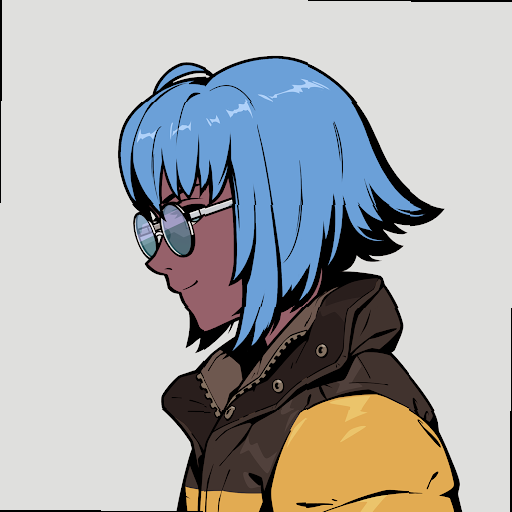

In [17]:
# Test azuki plagiarism
azuki_plagiarism_sample_path = os.path.join(azuki_plagiarism_path, random.choice(azuki_plagiarism_test_file_list))
azuki_plagiarism_sample_file = open(azuki_plagiarism_sample_path, "rb").read()
azuki_plagiarism_sample_image = Image.open(BytesIO(azuki_plagiarism_sample_file))
azuki_plagiarism_sample_image.show()

In [38]:
test_result = check_and_register(azuki_plagiarism_sample_file)

In [39]:
print(test_result)

{"plagiarism": true, "orig_img_cid": "QmdXuzkdeaSF22XkUbDZudgEFwguZ8EvA921Mri3M4RKwj", "orig_img_file": "iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAEAAElEQVR4nOyddXzcRtOAZ1bSoc/MHCcOcxrmpGmbtE2ZmZmZ+S0zM0NKaZo0TRpmZjYzn32M0u77h+yLOWe4xLH1fO/vq7RarXQX38zuzOwM5uZmg4KCgoJCz4Oc6BdQUFBQUDgxKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOihKApAQUFBoYeiKAAFBQWFHoqiABQUFBR6KIoCUFBQUOih8Cf6BRQUTgIQsaVLDAAYO47voqDQaSgKQKGnIwt3bAggEkKAMUn0ShK1222iKEGdGsB6d+r1ekHgOV5gAFSijFHGGABQShXdoNDFURSAQs/CJ+IJIYBAJep2uex2u8VsNtbUmGuq8wo